   # Import Data

In [47]:
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

When importing the data, set dtype as none to automatically determine the data type of each variable, and set names as true to assign the first line as headers for each variable.

In [7]:
data = np.genfromtxt('recs2009_public.csv', delimiter=',', dtype = None, names=True)

In [8]:
data['DOEID']

array([    1,     2,     3, ..., 12081, 12082, 12083])

In [9]:
data.shape

(12083,)

# Process Variables Relating to Energy Star

In [17]:
import csv
file = open('public_layout.csv', 'r')
reader = csv.reader(file, delimiter = ',')
reference = list(reader)

In [29]:
print reference[4][1]   #check if the file has been imported correctly

Reportable states and groups of states


In [36]:
import string

In [80]:
es_fieldNames = []
for i in xrange(len(reference)):
    if 'Energy Star'.lower() in reference[i][1].lower():    #exclude the impact of upper and lower case of the strings
        es_fieldNames += [[reference[i][0], reference[i][1]]]

In [81]:
print es_fieldNames

[['ESFRIG', 'Energy Star most-used refrigerator'], ['ESFRIG2', 'Energy Star second most-used refrigerator'], ['ESFRIG3', 'Energy Star third most-used refrigerator'], ['ESDISHW', 'Energy Star dishwasher'], ['ESCWASH', 'Energy Star clothes washer'], ['ESWWAC', 'Energy Star most-used window/wall air conditioning unit']]


Double check if the variables are related to home appliances and energy star certification.

Then we try to figure out the unique values for each variable we have chosen.

In [82]:
for i in xrange(len(es_fieldNames)):
    print "For {}, its unique values are {}".format(es_fieldNames[i][1], np.unique(data[es_fieldNames[i][0]]))

For Energy Star most-used refrigerator, its unique values are [-9 -8 -2  0  1]
For Energy Star second most-used refrigerator, its unique values are [-9 -2  0  1]
For Energy Star third most-used refrigerator, its unique values are [-9 -2  0  1]
For Energy Star dishwasher, its unique values are [-9 -8 -2  0  1]
For Energy Star clothes washer, its unique values are [-9 -8 -2  0  1]
For Energy Star most-used window/wall air conditioning unit, its unique values are [-9 -8 -2  0  1]


# Exploring Correlation and Regression

We try to factorize the energy star rating of refridgerators into 0.7:0.2:0.1 for most-used, second most, and third most refridgerators, and plot their relationship between the electricity consumed by refridgerators. 

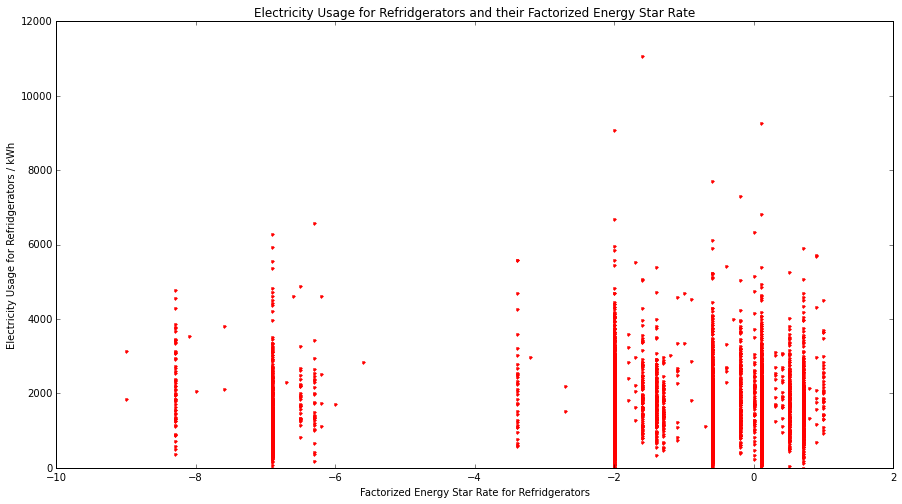

In [214]:
plt.figure(figsize=(15,8))
plt.plot(data[es_fieldNames[0][0]]*0.7+data[es_fieldNames[1][0]]*0.2+data[es_fieldNames[2][0]]*0.1, data['KWHRFG'], '.r')
plt.xlabel('Factorized Energy Star Rate for Refridgerators')
plt.ylabel('Electricity Usage for Refridgerators / kWh')
plt.title('Electricity Usage for Refridgerators and their Factorized Energy Star Rate')

From the plot we can figure out that there might be some subtle linear regression between the factorized energy star rate for refridgerators and the electricity usage of them. 

In [156]:
trainData = data[:len(data)/2]
testData = data[len(data)/2:]

In [159]:
def designMatrix(data):
    designMatrix = np.zeros((len(data), 2))
    for i in xrange(len(designMatrix)):
        designMatrix[i][0] = (data[es_fieldNames[0][0]]*0.7+data[es_fieldNames[1][0]]*0.2+data[es_fieldNames[2][0]]*0.1)[i]
        designMatrix[i][1] = 1
    return designMatrix

In [160]:
designMatrix_train = designMatrix(trainData)

In [162]:
betaHat_1 = np.linalg.inv(designMatrix_train.T.dot(designMatrix_train)).dot((designMatrix_train).T)
betaHat = betaHat_1.dot((np.asmatrix(trainData['KWHRFG']).T))

In [163]:
print betaHat

[[  -24.83443175]
 [ 1211.18453893]]


In [164]:
designMatrix_test = designMatrix(testData)
yHat = designMatrix_test.dot(betaHat)

In [165]:
def factorize(data):
    return data[es_fieldNames[0][0]]*0.7+data[es_fieldNames[1][0]]*0.2+data[es_fieldNames[2][0]]*0.1plt.ylabel('Electricty Usage for Refridgerators / kWh')

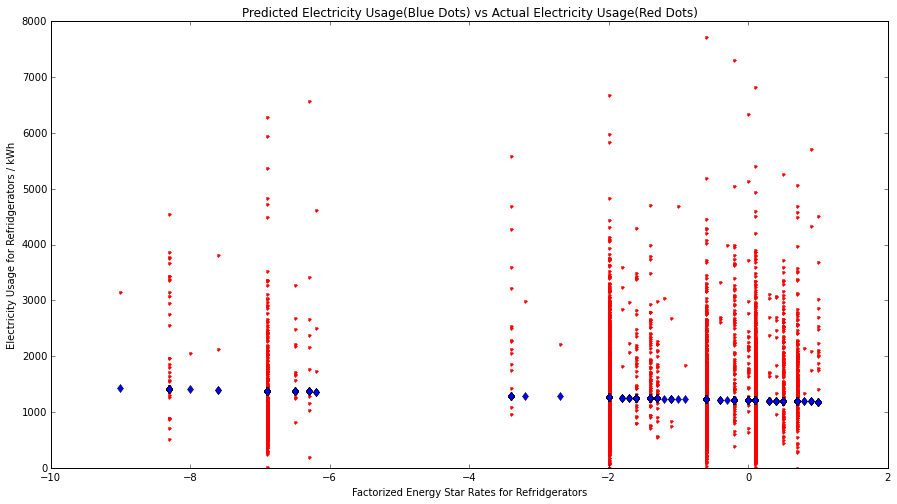

In [175]:
plt.figure(figsize=(15, 8))
plt.plot(factorize(testData), testData['KWHRFG'],'.r', factorize(testData), yHat, 'bd')
plt.xlabel('Factorized Energy Star Rates for Refridgerators')
plt.ylabel('Electricity Usage for Refridgerators / kWh')
plt.title('Predicted Electricity Usage(Blue Dots) vs Actual Electricity Usage(Red Dots)')

# Assessing Regression

In [200]:
y_matrix = np.asmatrix(testData['KWHRFG']).T
error = y_matrix - yHat
y_average = np.mean(testData['KWHRFG'])
R_squared = float(1 - (np.transpose(error)).dot(error) / ((y_matrix - y_average).T.dot(y_matrix - y_average)))

In [201]:
print R_squared

0.00412011721089


Judging from the r squared value, which is very low, the model we chose to fit the data doesn't work very well on interpreting the correlation between energy star rates of refridgerators and electricity consumption by refridgerators.

The we use hypothesis test to figure out the significant of factorized energy star rates for refridgerators. Assume the value of alpha is 0.01. Let null hypothesis be H0: beta = 0. 

In [202]:
new_Matrix = np.asmatrix(testData['KWHRFG'][:]).T-yHat[:]
MSE = 0
for i in xrange(len(new_Matrix)):
    MSE += new_Matrix[i]**2
MSE_new = MSE / (len(testData)-2)
s_square = float(MSE_new) * np.linalg.inv(designMatrix_test.T.dot(designMatrix_test))

In [203]:
print s_square

[[  26.01068705   31.50513257]
 [  31.50513257  137.52244578]]


In [204]:
from scipy.stats import t

In [205]:
for i in xrange(len(betaHat)):
    t_test = betaHat[i] / np.sqrt(np.array(s_square)[i][i])
    t_boundary = t.isf(0.01/2, len(testData)-2)
    if abs(t_test) > t_boundary:
        #print t_test, t_boundary
        print "For beta value {}, reject the null hypothesis.".format(float(betaHat[i]))

For beta value -24.8344317545, reject the null hypothesis.
For beta value 1211.18453893, reject the null hypothesis.


However, we can see that for 0.01 level of significance, all the beta values reject the null hypothesis, meaning that there should be correlations between the energy star refridgerators and the energy consumption of them, but not as obvious as what we firstly thought.

# Extend to Total Electricity Usage

Since almost all of the home appliances mentioned in the energy star consume electricity to keep working. As a result, it is reasonable to figure out the correlation among those ratings and the total electricity usage for the residential buildings investigated.

Here we assume there are multi-variate linear regressions among the appliances mentioned in energy star and the total electricity usage.

In [188]:
def designMatrixNew(data):
    matrix = np.zeros((len(data), 7))
    for i in xrange(len(data)):
        matrix[i][6] = 1
        for j in xrange(len(es_fieldNames)):
            matrix[i][j] = data[es_fieldNames[j][0]][i]
    return matrix

In [190]:
designMatrixNew_train = designMatrixNew(trainData)

In [191]:
print designMatrixNew_train.shape

(6041, 7)


In [195]:
betaHatNew_1 = np.linalg.inv(designMatrixNew_train.T.dot(designMatrixNew_train)).dot((designMatrixNew_train).T)
betaHatNew = betaHatNew_1.dot((np.asmatrix(trainData['KWH']).T))

In [196]:
print betaHatNew

[[   -17.44320618]
 [   378.76518472]
 [   623.64651609]
 [   210.48803696]
 [   292.18806141]
 [  -384.16694185]
 [ 13142.08648282]]


In [197]:
yHatNew = designMatrixNew(testData).dot(betaHatNew)

Evaluate the regression using r squared value.

In [198]:
y_matrix = np.asmatrix(testData['KWH']).T
error = y_matrix - yHatNew
y_average = np.mean(testData['KWH'])
R_squared = float(1 - (np.transpose(error)).dot(error) / ((y_matrix - y_average).T.dot(y_matrix - y_average)))

In [199]:
print R_squared

0.0261415299493


Then conduct hypothesis test based on alpha value 0.01 and null hypothesis: H0: beta = 0.

In [208]:
MSE = 0
new_Matrix = np.asmatrix(testData['KWH'][:]).T-yHatNew[:]
for i in xrange(len(new_Matrix)):
    MSE += new_Matrix[i]**2
MSE_new = MSE / (len(testData)-len(betaHatNew))

In [210]:
newDesignMatrix_testData = designMatrixNew(testData)

In [211]:
s_square = float(MSE_new) * np.linalg.inv(newDesignMatrix_testData.T.dot(newDesignMatrix_testData))

In [213]:
for i in xrange(len(betaHatNew)):
    t_test = betaHatNew[i] / np.sqrt(np.array(s_square)[i][i])
    t_boundary = t.isf(0.01/2, len(testData)-2)
    if abs(t_test) > t_boundary:
        #print t_test, t_boundary
        print "For beta value {}, reject the null hypothesis.".format(float(betaHatNew[i]))

For beta value 378.765184722, reject the null hypothesis.
For beta value 623.646516087, reject the null hypothesis.
For beta value 210.488036963, reject the null hypothesis.
For beta value 292.188061407, reject the null hypothesis.
For beta value -384.166941845, reject the null hypothesis.
For beta value 13142.0864828, reject the null hypothesis.
